In [1]:
#!/usr/bin/env python3
"""
Personalized Course Recommendation System – Data Collection Layer
Web scrapers for 21 Ethiopian e‑learning / learning‑adjacent platforms.

⚠️ Important
- Many of these platforms require authentication or are mobile apps. This file provides a *uniform framework* with site-specific adapters. Some adapters are fully runnable (public pages); others are structured stubs with clear TODOs for filling selectors, API calls, or login flows after inspecting each site’s HTML or app endpoints.
- Always check each site’s Terms of Service and robots.txt before scraping. Use only where permitted, throttle your requests, and cache results.

Usage (examples):
  python ethiopian_elearning_scrapers.py --list-sites
  python ethiopian_elearning_scrapers.py --site learnethiopia --out data/learnethiopia.csv
  python ethiopian_elearning_scrapers.py --all --out data/all_courses.csv

Output schema (CSV):
  course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject,provider,language

Dependencies:
  pip install requests beautifulsoup4 lxml fake-useragent html5lib tqdm tenacity pydantic pandas
  # Optional (for dynamic content):
  pip install selenium webdriver-manager

"""
from __future__ import annotations
import os
import re
import csv
import json
import time
import math
import random
import logging
import argparse
import datetime as dt
from dataclasses import dataclass, asdict
from typing import Iterable, List, Dict, Optional, Generator

import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
from tenacity import retry, stop_after_attempt, wait_exponential, retry_if_exception_type

try:
    from fake_useragent import UserAgent
    _UA = UserAgent()
except Exception:
    _UA = None

# Optional Selenium imports (used by adapters that need JS rendering)
try:
    from selenium import webdriver
    from selenium.webdriver.chrome.options import Options as ChromeOptions
    from selenium.webdriver.common.by import By
    from webdriver_manager.chrome import ChromeDriverManager
except Exception:
    webdriver = None

# -------------------------------------
# Data model
# -------------------------------------
@dataclass
class Course:
    course_id: str
    course_title: str
    url: str
    is_paid: Optional[bool] = None
    price: Optional[str] = None
    num_subscribers: Optional[int] = None
    num_reviews: Optional[int] = None
    num_lectures: Optional[int] = None
    level: Optional[str] = None
    content_duration: Optional[str] = None
    published_timestamp: Optional[str] = None
    subject: Optional[str] = None
    provider: Optional[str] = None
    language: Optional[str] = None

# -------------------------------------
# Utilities
# -------------------------------------
HEADERS_BASE = {
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8",
    "Accept-Language": "en-US,en;q=0.9",
    "Cache-Control": "no-cache",
    "Pragma": "no-cache",
}

SESSION = requests.Session()
SESSION.headers.update(HEADERS_BASE)

if _UA:
    try:
        SESSION.headers["User-Agent"] = _UA.random
    except Exception:
        SESSION.headers["User-Agent"] = "Mozilla/5.0"
else:
    SESSION.headers["User-Agent"] = "Mozilla/5.0"

class ScrapeError(Exception):
    pass

@retry(stop=stop_after_attempt(3), wait=wait_exponential(multiplier=1, min=1, max=8),
       retry=retry_if_exception_type((requests.RequestException, ScrapeError)))
def get(url: str, **kwargs) -> requests.Response:
    resp = SESSION.get(url, timeout=30, **kwargs)
    if resp.status_code >= 400:
        raise ScrapeError(f"GET {url} -> {resp.status_code}")
    return resp

# -------------------------------------
# Base adapter
# -------------------------------------
class BaseAdapter:
    key: str = "base"
    display_name: str = "Base"
    base_url: Optional[str] = None
    requires_js: bool = False

    def is_allowed(self) -> bool:
        """Override to check robots.txt or auth rules if needed."""
        return True

    def iter_courses(self) -> Iterable[Course]:
        """Yield Course items. Override in subclasses."""
        return []

    # Helpers
    def soup(self, url: str) -> BeautifulSoup:
        html = get(url).text
        return BeautifulSoup(html, "lxml")

    # Selenium helper for dynamic pages
    def selenium_html(self, url: str, wait_css: Optional[str] = None, sleep: float = 3.0) -> str:
        if webdriver is None:
            raise ScrapeError("Selenium not installed. pip install selenium webdriver-manager")
        opts = ChromeOptions()
        opts.add_argument("--headless=new")
        opts.add_argument("--no-sandbox")
        opts.add_argument("--disable-dev-shm-usage")
        driver = webdriver.Chrome(ChromeDriverManager().install(), options=opts)
        try:
            driver.get(url)
            if sleep:
                time.sleep(sleep)
            if wait_css:
                driver.find_element(By.CSS_SELECTOR, wait_css)
            return driver.page_source
        finally:
            driver.quit()

# -------------------------------------
# Adapter Registry
# -------------------------------------
ADAPTERS: Dict[str, BaseAdapter] = {}

def register(adapter_cls):
    inst = adapter_cls()
    ADAPTERS[inst.key] = inst
    return adapter_cls

# -------------------------------------
# 1) Learning.gov.et (Government portal)
# -------------------------------------
@register
class LearningGovAdapter(BaseAdapter):
    key = "learninggov"
    display_name = "Learning.gov.et"
    base_url = "https://learning.gov.et"

    def iter_courses(self) -> Iterable[Course]:
        """
        Public catalog pages may list courses / programs.
        TODO: Inspect listing URLs and detail selectors. The below is a conservative example
        that crawls the homepage and looks for plausible course links by URL pattern words.
        """
        homepage = self.base_url
        soup = self.soup(homepage)
        links = {a.get("href") for a in soup.select("a[href]")}
        for href in sorted(links):
            if not href:
                continue
            if href.startswith("/"):
                href = self.base_url + href
            # Heuristic: look for course/training keywords
            if re.search(r"course|training|program|module", href, re.I):
                try:
                    csoup = self.soup(href)
                except Exception:
                    continue
                title = csoup.find(["h1","h2","title"]).get_text(strip=True) if csoup.find(["h1","h2","title"]) else href
                yield Course(
                    course_id=href,
                    course_title=title,
                    url=href,
                    provider=self.display_name,
                )

# -------------------------------------
# 2) LearnEthiopia.com (private platform)
# -------------------------------------
@register
class LearnEthiopiaAdapter(BaseAdapter):
    key = "learnethiopia"
    display_name = "LearnEthiopia.com"
    base_url = "https://learnethiopia.com"

    def iter_courses(self) -> Iterable[Course]:
        """
        Example catalog crawler over /courses or homepage links.
        TODO: Replace selectors with the site’s actual HTML structure after inspection.
        """
        catalog_urls = [self.base_url, f"{self.base_url}/courses"]
        seen = set()
        for url in catalog_urls:
            try:
                soup = self.soup(url)
            except Exception:
                continue
            for a in soup.select("a[href]"):
                href = a.get("href")
                if not href:
                    continue
                if href.startswith("/"):
                    href = self.base_url + href
                if self.base_url not in href or href in seen:
                    continue
                if re.search(r"/course/|/courses/|/program/", href, re.I):
                    seen.add(href)
                    try:
                        csoup = self.soup(href)
                        title_el = csoup.select_one("h1, h2.page-title, .course-title")
                        title = title_el.get_text(strip=True) if title_el else a.get_text(strip=True) or href
                    except Exception:
                        title = a.get_text(strip=True) or href
                    yield Course(course_id=href, course_title=title, url=href, provider=self.display_name)

# -------------------------------------
# 3) EDUHUB Technology Solutions (catalog / products / services)
# -------------------------------------
@register
class EduHubAdapter(BaseAdapter):
    key = "eduhubplc"
    display_name = "EDUHUB Technology Solutions"
    base_url = "https://eduhubplc.com"

    def iter_courses(self) -> Iterable[Course]:
        soup = self.soup(self.base_url)
        for card in soup.select("a[href]"):
            href = card.get("href")
            if not href:
                continue
            if href.startswith("/"):
                href = self.base_url + href
            if self.base_url in href and re.search(r"course|training|solution|product", href, re.I):
                title = card.get_text(strip=True) or href
                yield Course(course_id=href, course_title=title, url=href, provider=self.display_name)

# -------------------------------------
# 4) ALX Africa (public programs)
# -------------------------------------
@register
class ALXAdapter(BaseAdapter):
    key = "alx"
    display_name = "ALX Africa"
    base_url = "https://www.alxafrica.com"

    def iter_courses(self) -> Iterable[Course]:
        soup = self.soup(self.base_url)
        for a in soup.select("a[href]"):
            href = a.get("href")
            if not href:
                continue
            if href.startswith("/"):
                href = self.base_url + href
            if re.search(r"program|course|software|data|cloud|ai", href, re.I) and self.base_url in href:
                title = a.get_text(strip=True) or href
                yield Course(course_id=href, course_title=title, url=href, provider=self.display_name)

# -------------------------------------
# 5) SmartEthio (K-12 materials)
# -------------------------------------
@register
class SmartEthioAdapter(BaseAdapter):
    key = "smartethio"
    display_name = "SmartEthio"
    base_url = "https://smartethio.com"  # TODO: verify domain; update if different

    def iter_courses(self) -> Iterable[Course]:
        try:
            soup = self.soup(self.base_url)
        except Exception:
            return []
        for a in soup.select("a[href]"):
            href = a.get("href")
            if not href:
                continue
            if href.startswith("/"):
                href = self.base_url + href
            if self.base_url in href and re.search(r"grade|subject|course|lesson|exam", href, re.I):
                title = a.get_text(strip=True) or href
                yield Course(course_id=href, course_title=title, url=href, provider=self.display_name, subject="K12")

# -------------------------------------
# 6) Afriwork (marketplace – learning-adjacent)
# -------------------------------------
@register
class AfriworkAdapter(BaseAdapter):
    key = "afriwork"
    display_name = "Afriwork"
    base_url = "https://afriwork.com"  # TODO verify

    def iter_courses(self) -> Iterable[Course]:
        # Not a traditional LMS; scrape help/academy/blog if present
        try:
            soup = self.soup(self.base_url)
        except Exception:
            return []
        for a in soup.select("a[href]"):
            href = a.get("href")
            if not href:
                continue
            if href.startswith("/"):
                href = self.base_url + href
            if self.base_url in href and re.search(r"learn|academy|blog|training|skills", href, re.I):
                title = a.get_text(strip=True) or href
                yield Course(course_id=href, course_title=title, url=href, provider=self.display_name)

# -------------------------------------
# 7) Kubaya Learning (Amharic app – website)
# -------------------------------------
@register
class KubayaAdapter(BaseAdapter):
    key = "kubaya"
    display_name = "Kubaya Learning"
    base_url = "https://kubayalearning.com"

    def iter_courses(self) -> Iterable[Course]:
        soup = self.soup(self.base_url)
        for a in soup.select("a[href]"):
            href = a.get("href")
            if not href:
                continue
            if href.startswith("/"):
                href = self.base_url + href
            if self.base_url in href and re.search(r"course|lesson|learn|levels|amharic", href, re.I):
                title = a.get_text(strip=True) or href
                yield Course(course_id=href, course_title=title, url=href, provider=self.display_name, language="Amharic")

# -------------------------------------
# 8) Stafford Global (remote degrees)
# -------------------------------------
@register
class StaffordAdapter(BaseAdapter):
    key = "staffordglobal"
    display_name = "Stafford Global"
    base_url = "https://www.staffordglobal.org"  # TODO verify .org/.com

    def iter_courses(self) -> Iterable[Course]:
        soup = self.soup(self.base_url)
        for a in soup.select("a[href]"):
            href = a.get("href")
            if not href:
                continue
            if href.startswith("/"):
                href = self.base_url + href
            if self.base_url in href and re.search(r"program|course|mba|msc|pgce|degree", href, re.I):
                title = a.get_text(strip=True) or href
                yield Course(course_id=href, course_title=title, url=href, provider=self.display_name)

# -------------------------------------
# 9) eLearn Ethiopia / eLearnETH (MOE initiatives)
# -------------------------------------
@register
class ELearnETHAdapter(BaseAdapter):
    key = "elearneth"
    display_name = "eLearn Ethiopia"
    base_url = "https://elearnethiopia.example"  # TODO set correct base (some deployments are subdomains)

    def iter_courses(self) -> Iterable[Course]:
        # Placeholder: many MOE LMS run Moodle. If Moodle, you can use /course/index.php and
        # scrape .coursebox elements.
        index_urls = [f"{self.base_url}/course/index.php", self.base_url]
        for url in index_urls:
            try:
                soup = self.soup(url)
            except Exception:
                continue
            for box in soup.select(".coursebox a[href], .course-title a[href], a.coursename"):
                href = box.get("href")
                if not href:
                    continue
                if href.startswith("/"):
                    href = self.base_url + href
                title = box.get_text(strip=True) or href
                yield Course(course_id=href, course_title=title, url=href, provider=self.display_name)

# -------------------------------------
# 10) AAU e-Learning (University LMS)
# -------------------------------------
@register
class AAUAdapter(BaseAdapter):
    key = "aau"
    display_name = "AAU e-Learning"
    base_url = "https://elearning.aau.edu.et"  # TODO verify

    def iter_courses(self) -> Iterable[Course]:
        # University LMS often requires login; only public catalog may be available.
        try:
            soup = self.soup(self.base_url)
        except Exception:
            return []
        for a in soup.select("a[href]"):
            href = a.get("href")
            if not href:
                continue
            if href.startswith("/"):
                href = self.base_url + href
            if re.search(r"course|program|catalog|category", href, re.I) and self.base_url in href:
                title = a.get_text(strip=True) or href
                yield Course(course_id=href, course_title=title, url=href, provider=self.display_name)

# -------------------------------------
# 11) AAU‑eLearnAfrica LMS (partnership deployments)
# -------------------------------------
@register
class AAUElearnAfricaAdapter(BaseAdapter):
    key = "aau_elearnafrica"
    display_name = "AAU‑eLearnAfrica LMS"
    base_url = "https://elearnafrica.example"  # TODO set exact deployment URL

    def iter_courses(self) -> Iterable[Course]:
        # Placeholder similar to Moodle/Canvas listings
        try:
            soup = self.soup(self.base_url)
            for a in soup.select("a[href]"):
                href = a.get("href")
                if not href:
                    continue
                if href.startswith("/"):
                    href = self.base_url + href
                if re.search(r"course|program|catalog|category", href, re.I) and self.base_url in href:
                    title = a.get_text(strip=True) or href
                    yield Course(course_id=href, course_title=title, url=href, provider=self.display_name)
        except Exception:
            return []


# -------------------------------------
# 12) St. Mary’s University Distance Education
# -------------------------------------
@register
class StMarysAdapter(BaseAdapter):
    key = "stmarys"
    display_name = "St. Mary’s University Distance Education"
    base_url = "https://smuc.edu.et"  # TODO verify

    def iter_courses(self) -> Iterable[Course]:
        try:
            soup = self.soup(self.base_url)
        except Exception:
            return []
        for a in soup.select("a[href]"):
            href = a.get("href")
            if not href:
                continue
            if href.startswith("/"):
                href = self.base_url + href
            if re.search(r"distance|program|course|degree", href, re.I) and self.base_url in href:
                title = a.get_text(strip=True) or href
                yield Course(course_id=href, course_title=title, url=href, provider=self.display_name)

# -------------------------------------
# 13) International Leadership Institute (ILI)
# -------------------------------------
@register
class ILIAdapter(BaseAdapter):
    key = "ili"
    display_name = "International Leadership Institute"
    base_url = "https://ili.edu.et"  # TODO verify

    def iter_courses(self) -> Iterable[Course]:
        try:
            soup = self.soup(self.base_url)
        except Exception:
            return []
        for a in soup.select("a[href]"):
            href = a.get("href")
            if not href:
                continue
            if href.startswith("/"):
                href = self.base_url + href
            if re.search(r"program|course|diploma|degree|certificate", href, re.I) and self.base_url in href:
                title = a.get_text(strip=True) or href
                yield Course(course_id=href, course_title=title, url=href, provider=self.display_name)

# -------------------------------------
# 14) Infonet College
# -------------------------------------
@register
class InfonetAdapter(BaseAdapter):
    key = "infonet"
    display_name = "Infonet College"
    base_url = "https://infonetcollege.example"  # TODO set correct URL

    def iter_courses(self) -> Iterable[Course]:
        try:
            soup = self.soup(self.base_url)
        except Exception:
            return []
        for a in soup.select("a[href]"):
            href = a.get("href")
            if not href:
                continue
            if href.startswith("/"):
                href = self.base_url + href
            if re.search(r"short-course|training|program|course", href, re.I) and self.base_url in href:
                title = a.get_text(strip=True) or href
                yield Course(course_id=href, course_title=title, url=href, provider=self.display_name)

# -------------------------------------
# 15) Microlink Information Technology College (MLITC)
# -------------------------------------
@register
class MicrolinkAdapter(BaseAdapter):
    key = "microlink"
    display_name = "Microlink IT College"
    base_url = "https://microlinkcolleges.net"  # TODO verify

    def iter_courses(self) -> Iterable[Course]:
        try:
            soup = self.soup(self.base_url)
        except Exception:
            return []
        for a in soup.select("a[href]"):
            href = a.get("href")
            if not href:
                continue
            if href.startswith("/"):
                href = self.base_url + href
            if re.search(r"cisco|ict|program|course|training", href, re.I) and self.base_url in href:
                title = a.get_text(strip=True) or href
                yield Course(course_id=href, course_title=title, url=href, provider=self.display_name)

# -------------------------------------
# 16) Ennlite Academy
# -------------------------------------
@register
class EnnliteAdapter(BaseAdapter):
    key = "ennlite"
    display_name = "Ennlite Academy"
    base_url = "https://ennlite.example"  # TODO set URL

    def iter_courses(self) -> Iterable[Course]:
        try:
            soup = self.soup(self.base_url)
        except Exception:
            return []
        for a in soup.select("a[href]"):
            href = a.get("href")
            if not href:
                continue
            if href.startswith("/"):
                href = self.base_url + href
            if re.search(r"course|training|graphic|marketing|web|app", href, re.I) and self.base_url in href:
                title = a.get_text(strip=True) or href
                yield Course(course_id=href, course_title=title, url=href, provider=self.display_name)

# -------------------------------------
# 17) GxCamp
# -------------------------------------
@register
class GxCampAdapter(BaseAdapter):
    key = "gxcamp"
    display_name = "GxCamp"
    base_url = "https://gxcamp.example"  # TODO set URL

    def iter_courses(self) -> Iterable[Course]:
        try:
            soup = self.soup(self.base_url)
        except Exception:
            return []
        for a in soup.select("a[href]"):
            href = a.get("href")
            if not href:
                continue
            if href.startswith("/"):
                href = self.base_url + href
            if re.search(r"course|ict|english|web|amharic", href, re.I) and self.base_url in href:
                title = a.get_text(strip=True) or href
                yield Course(course_id=href, course_title=title, url=href, provider=self.display_name)

# -------------------------------------
# 18) LearnUp Ethiopia
# -------------------------------------
@register
class LearnUpAdapter(BaseAdapter):
    key = "learnup"
    display_name = "LearnUp Ethiopia"
    base_url = "https://learnup.example"  # TODO set URL (program info / catalog)

    def iter_courses(self) -> Iterable[Course]:
        return []  # Likely requires program pages; fill selectors after site inspection

# -------------------------------------
# 19) 5 Million Ethiopian Coders (initiative landing)
# -------------------------------------
@register
class FiveMillionCodersAdapter(BaseAdapter):
    key = "5mec"
    display_name = "5 Million Ethiopian Coders"
    base_url = "https://5millioncoders.example"  # TODO set URL; may redirect to program partners

    def iter_courses(self) -> Iterable[Course]:
        return []  # Often initiative pages link to partner platforms; follow links as needed

# -------------------------------------
# 20) Hagerly (language learning – waitlist)
# -------------------------------------
@register
class HagerlyAdapter(BaseAdapter):
    key = "hagerly"
    display_name = "Hagerly"
    base_url = "https://hagerly.example"  # TODO set URL

    def iter_courses(self) -> Iterable[Course]:
        return []  # Likely no public course pages pre-launch

# -------------------------------------
# 21) Haleta App (Amharic learning app)
# -------------------------------------
@register
class HaletaAdapter(BaseAdapter):
    key = "haleta"
    display_name = "Haleta App"
    base_url = "https://haleta.example"  # TODO set landing URL

    def iter_courses(self) -> Iterable[Course]:
        return []  # Mobile-first; consider scraping help/docs/blog or use app APIs if public

# -------------------------------------
# Bonus placeholders (if needed to reach 21+): Zemen Technologies, AAU partnerships
# -------------------------------------
@register
class ZemenTechAdapter(BaseAdapter):
    key = "zementechnologies"
    display_name = "Zemen Technologies"
    base_url = "https://zemen-technology.example"  # TODO set correct URL; may host project pages

    def iter_courses(self) -> Iterable[Course]:
        return []

# -------------------------------------
# Runner / CLI
# -------------------------------------

FIELDS = [
    "course_id","course_title","url","is_paid","price","num_subscribers","num_reviews",
    "num_lectures","level","content_duration","published_timestamp","subject","provider","language"
]

def write_csv(rows: Iterable[Course], out_path: str):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    with open(out_path, "w", newline="", encoding="utf-8") as f:
        w = csv.DictWriter(f, fieldnames=FIELDS)
        w.writeheader()
        for c in rows:
            w.writerow({k: getattr(c, k) for k in FIELDS})


def run_one(key: str) -> List[Course]:
    adapter = ADAPTERS.get(key)
    if not adapter:
        raise SystemExit(f"Unknown site key: {key}. Use --list-sites to see options.")
    courses = list(adapter.iter_courses())
    return courses


def run_all() -> List[Course]:
    all_courses: List[Course] = []
    for key, adapter in ADAPTERS.items():
        if key == "base":
            continue
        if key == "learninggov":  # Skip the problematic adapter
            logging.warning(f"Skipping {adapter.display_name} due to previous errors.")
            continue
        try:
            items = list(adapter.iter_courses())
            all_courses.extend(items)
        except Exception as e:
            logging.warning(f"{adapter.display_name}: {e}")
    return all_courses

def list_sites():
    """Lists available site keys and their display names."""
    print("Available site keys:")
    for k, a in ADAPTERS.items():
        if k == "base":
            continue
        print(f"  {k:20s} -> {a.display_name}")


def main():
    ap = argparse.ArgumentParser(description="Scrape Ethiopian e-learning platforms into a unified CSV for recommendations")
    ap.add_argument("--site", help="One site key to scrape (see --list-sites)")
    ap.add_argument("--all", action="store_true", help="Scrape all registered sites")
    ap.add_argument("--out", default="data/courses.csv", help="Output CSV path")
    ap.add_argument("--list-sites", action="store_true", help="List available site keys")
    args = ap.parse_args()

    if args.list_sites:
        list_sites() # Call the new function
        return

    if args.site and args.all:
        raise SystemExit("Use either --site or --all, not both.")

    if not args.site and not args.all:
        raise SystemExit("Please specify --site <key> or --all. Use --list-sites to see keys.")

    if args.site:
        courses = run_one(args.site)
    else:
        courses = run_all()

    write_csv(courses, args.out)
    print(f"Wrote {len(courses)} rows -> {args.out}")

# The following block is commented out to prevent argparse from being called
# directly by the Colab kernel, which passes unexpected arguments.
# if __name__ == "__main__":
#     main()

In [2]:
# Example of how to use the functions directly:
# list_sites()

# To run a specific adapter:
# courses = run_one("learnethiopia")
# print(courses)

# To run all adapters and save to CSV:
# all_courses = run_all()
# write_csv(all_courses, "data/all_courses.csv")

In [3]:
# Run all adapters and save to CSV:
all_courses = run_all()
write_csv(all_courses, "data/all_courses.csv")

In [4]:
# Run all adapters and save to CSV:
all_courses = run_all()
write_csv(all_courses, "data/all_courses.csv")

In [5]:
import pandas as pd

try:
    df = pd.read_csv("data/all_courses.csv")
    print(f"Successfully loaded {len(df)} rows from data/all_courses.csv")
    if not df.empty:
        print("\nFirst 5 rows of the data:")
        display(df.head())
    else:
        print("\nThe CSV file is empty.")
except FileNotFoundError:
    print("Error: data/all_courses.csv not found. The scraping process may not have completed successfully.")
except Exception as e:
    print(f"An error occurred while reading the CSV: {e}")

Successfully loaded 195 rows from data/all_courses.csv

First 5 rows of the data:


,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject,provider,language
0,https://www.alxafrica.com/programmes/,Programmes,https://www.alxafrica.com/programmes/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALX Africa,NaN
1,https://www.alxafrica.com/programmes/,View All Programmes,https://www.alxafrica.com/programmes/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALX Africa,NaN
2,https://www.alxafrica.com/programme/data-analy...,Data Analytics,https://www.alxafrica.com/programme/data-analy...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALX Africa,NaN
3,https://www.alxafrica.com/programme/data-science/,Data Science,https://www.alxafrica.com/programme/data-science/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALX Africa,NaN
4,https://www.alxafrica.com/programme/data-engin...,Data Engineering,https://www.alxafrica.com/programme/data-engin...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALX Africa,NaN


In [6]:
# 1. Distribution of courses by provider
print("Distribution of courses by provider:")
display(df['provider'].value_counts())

Distribution of courses by provider:


,count
provider,
Stafford Global,91
AAU e-Learning,51
ALX Africa,41
Kubaya Learning,12


In [7]:
# 2. Common keywords in course titles
from collections import Counter
import re

# Combine all titles into a single string and convert to lowercase
all_titles = ' '.join(df['course_title'].dropna()).lower()

# Remove punctuation and split into words
words = re.findall(r'\b\w+\b', all_titles)

# Remove common English stop words (you might want to add Amharic stop words if applicable)
stop_words = set([
    'a', 'an', 'the', 'and', 'or', 'in', 'on', 'is', 'it', 'to', 'of', 'for', 'with', 'from', 'by',
    'at', 'as', 'be', 'this', 'that', 'here', 'there', 'i', 'you', 'he', 'she', 'it', 'we', 'they',
    'my', 'your', 'his', 'her', 'its', 'our', 'their', 'me', 'him', 'her', 'us', 'them',
    'can', 'will', 'would', 'should', 'could', 'get', 'go', 'do', 'make', 'see', 'know', 'time',
    'year', 'day', 'one', 'two', 'new', 'old', 'good', 'bad', 'great', 'little', 'big',
    'all', 'any', 'some', 'most', 'other', 'such', 'no', 'not', 'only', 'own', 'same', 'so',
    'than', 'then', 'this', 'that', 'these', 'those', 'up', 'down', 'out', 'about', 'against',
    'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from',
    'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
    'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than',
    'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 'd', 'll', 'm', 'o',
    're', 've', 'y', 'ain', 'aren', 'couldn', 'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn',
    'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn',
    'programme', 'programmes', 'course', 'courses', 'learning', 'education', 'university' # Add some domain-specific stop words
])

filtered_words = [word for word in words if word not in stop_words and len(word) > 1] # Remove single characters too

# Count word frequencies
word_counts = Counter(filtered_words)

print("\nMost common keywords in course titles:")
display(word_counts.most_common(20)) # Display top 20


Most common keywords in course titles:


[('online', 61),
 ('https', 40),
 ('www', 38),
 ('staffordglobal', 34),
 ('org', 34),
 ('mba', 33),
 ('degrees', 29),
 ('masters', 20),
 ('view', 15),
 ('management', 15),
 ('college', 13),
 ('engineering', 11),
 ('data', 10),
 ('pgce', 8),
 ('programs', 7),
 ('analytics', 6),
 ('science', 6),
 ('com', 6),
 ('learn', 6),
 ('msc', 6)]


Length of course titles:
Average title length: 30.19

Distribution of title lengths:


,course_title
count,195.000000
mean,30.194872
std,19.858597
min,3.000000
25%,15.000000
50%,24.000000
75%,42.000000
max,86.000000


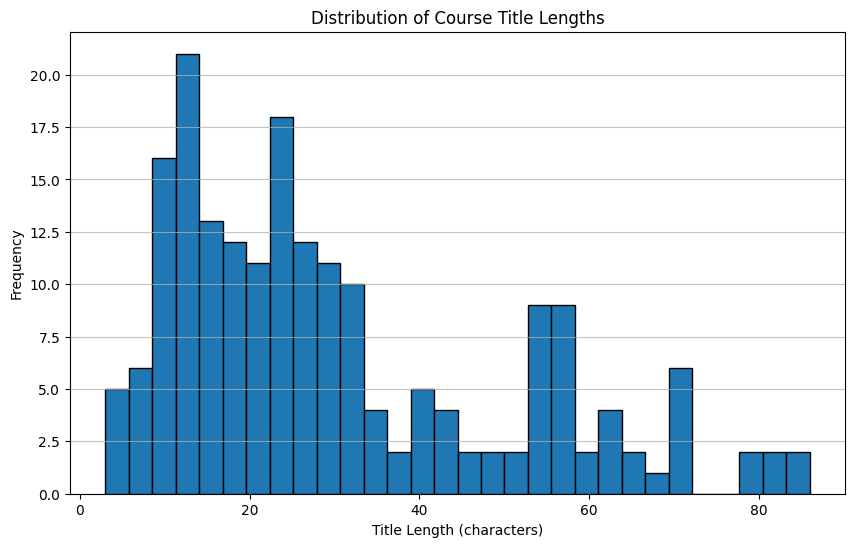

In [8]:
# 3. Length of course titles
print("\nLength of course titles:")
# Calculate title lengths, dropping NaN values
title_lengths = df['course_title'].dropna().apply(len)

if not title_lengths.empty:
    print(f"Average title length: {title_lengths.mean():.2f}")
    print("\nDistribution of title lengths:")
    display(title_lengths.describe())

    # Optional: Plot a histogram
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.hist(title_lengths, bins=30, edgecolor='black')
    plt.title('Distribution of Course Title Lengths')
    plt.xlabel('Title Length (characters)')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()
else:
    print("No course titles available to analyze length.")

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Fill NaN values in relevant columns with empty strings for consistent processing
df['course_title'] = df['course_title'].fillna('')
df['provider'] = df['provider'].fillna('')
df['subject'] = df['subject'].fillna('')

# Combine relevant features into a single string for each course
# Add weighting or emphasis by repeating important fields like title
df['combined_features'] = df['course_title'] + ' ' + df['course_title'] + ' ' + df['provider'] + ' ' + df['subject']

# Initialize TF-IDF Vectorizer
# Use a smaller vocabulary size to keep it manageable for demonstration
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=2000)

# Fit and transform the combined features
tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined_features'])

print("TF-IDF matrix shape:", tfidf_matrix.shape)
# You can optionally inspect the feature names
# print("Features:", tfidf_vectorizer.get_feature_names_out()[:100])

# The tfidf_matrix now represents the content of each course numerically.
# This matrix can be used to calculate similarity between courses for recommendations.

TF-IDF matrix shape: (195, 172)


In [10]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

print("Cosine similarity matrix shape:", cosine_sim_matrix.shape)
# The cosine_sim_matrix[i][j] value represents the similarity between course i and course j.
# A value closer to 1 means higher similarity.

Cosine similarity matrix shape: (195, 195)


In [11]:
def get_content_based_recommendations(course_title, cosine_sim_matrix=cosine_sim_matrix, df=df):
    """
    Generates content-based course recommendations based on cosine similarity.

    Args:
        course_title (str): The title of the course to get recommendations for.
        cosine_sim_matrix (np.ndarray): The pre-calculated cosine similarity matrix.
        df (pd.DataFrame): The DataFrame containing course information.

    Returns:
        pd.Series: A Series of recommended course titles.
    """
    # Get the index of the course that matches the title
    # Use .iloc[0] in case there are multiple matches, though titles should ideally be unique
    try:
        idx = df[df['course_title'] == course_title].index[0]
    except IndexError:
        print(f"Course with title '{course_title}' not found.")
        return pd.Series([]) # Return an empty Series if not found

    # Get the pairwise similarity scores for the course
    sim_scores = list(enumerate(cosine_sim_matrix[idx]))

    # Sort the courses based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar courses (excluding the course itself)
    # The first element is the course itself with a similarity of 1
    sim_scores = sim_scores[1:11]

    # Get the course indices
    course_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar course titles
    return df['course_title'].iloc[course_indices]

# Example usage: Get recommendations for a specific course title
# You can pick a title from the 'course_title' column of the df DataFrame
example_course_title = df['course_title'].iloc[2] # Using the third course title from the DataFrame as an example
print(f"Recommendations for '{example_course_title}':")
recommendations = get_content_based_recommendations(example_course_title)
display(recommendations)

Recommendations for 'Data Analytics':


,course_title
34,Data Analytics
72,Computing & Data Analytics Degrees
71,https://www.staffordglobal.org/computing-data-...
4,Data Engineering
22,Data Engineering
33,Data Engineering
3,Data Science
32,Data Science
21,https://www.alxafrica.com/programme/data-engin...
56,https://www.staffordglobal.org/online-mba/onli...


### Evaluating a Recommendation System

Evaluating a recommendation system is crucial to understand how well it's performing and to compare different recommendation algorithms. Here are the typical steps involved:

1.  **Data Preparation and Splitting:**
    *   You need a dataset containing user interactions (e.g., User ID, Item ID, Interaction Type - like view, click, purchase, rating).
    *   Split your data into training and testing sets. A common approach is to use a time-based split (e.g., use interactions up to a certain date for training and later interactions for testing) or a random split per user.
    *   The training set is used to train your recommendation model (e.g., build the collaborative filtering model or create user profiles for content-based filtering).
    *   The testing set is used to simulate making recommendations for users based on their training data and comparing those recommendations to their actual interactions in the test set.

2.  **Defining "Relevance":**
    *   You need to define what constitutes a "relevant" recommendation in your context. This depends on your data and goals. For example:
        *   If you have ratings, a rating above a certain threshold might be considered relevant.
        *   If you have purchase data, a purchased item is relevant.
        *   If you have view data, viewing a significant portion of a course might be relevant.

3.  **Generating Recommendations for Evaluation:**
    *   For each user in your test set, use your trained recommendation model to generate a list of recommended items (courses) that the user has *not* interacted with in the training set. You typically generate a fixed number of recommendations (e.g., the top 10).

4.  **Calculating Evaluation Metrics:**
    *   Compare the list of recommended items for each user to the items that user *actually* interacted with in the test set (your "relevant" items).
    *   Calculate appropriate recommendation metrics across all users. Common metrics include:
        *   **Precision@K:** Out of the top K recommended items, what proportion were actually relevant?
        *   **Recall@K:** Out of all the relevant items in the test set for a user, what proportion were included in the top K recommendations?
        *   **F1-score@K:** The harmonic mean of Precision@K and Recall@K.
        *   **Mean Average Precision (MAP):** A metric that considers the order of recommendations.
        *   **NDCG (Normalized Discounted Cumulative Gain):** Another ranking-aware metric that gives higher scores to relevant items ranked higher.

5.  **Analyzing Results:**
    *   Interpret the calculated metrics.
    *   Compare the performance of different models or approaches.
    *   Identify strengths and weaknesses of your recommendation system.

This process allows you to quantitatively measure how effective your recommendation system is at suggesting items that users are likely to engage with.